In [27]:
import gtsam
from gtsam.utils import plot as gtsam_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [29]:
# read the factor graph from cvs file
select = "odom"

base_path = "/media/baymax/1A52-86C0/new"

df_1_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/1.csv')
df_2_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/2.csv')
df_3_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/3.csv')
df_4_gt = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/gt/4.csv')

df_2 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/2.csv')
df_1 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/1.csv')
df_3 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/3.csv')
df_4 = pd.read_csv(f'{base_path}/detected_loops/pose_data/sync/{select}/4.csv')

In [30]:
# convert to numpy array
arr_1_gt = df_1_gt.to_numpy()
arr_2_gt = df_2_gt.to_numpy()
arr_3_gt = df_3_gt.to_numpy()
arr_4_gt = df_4_gt.to_numpy()

arr_1 = df_1.to_numpy()
arr_2 = df_2.to_numpy()
arr_3 = df_3.to_numpy()
arr_4 = df_4.to_numpy()

In [31]:
print(arr_1.shape)

(511, 8)


In [32]:
a = gtsam.Pose3()
b = gtsam.Pose3(gtsam.Rot3(), gtsam.Point3(1, 0, 0))
print(a.between(b))

R: [
	1, 0, 0;
	0, 1, 0;
	0, 0, 1
]
t: 1 0 0



In [33]:
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# add prior factor
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.0001, 0.0001, 0.0001])
# pose_key = gtsam.symbol('o', 0)
# gt = gtsam.PriorFactorPose3(pose_key, gtsam.Pose3(), prior_noise)
noise_odom = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01])
noise_loop = gtsam.noiseModel.Diagonal.Sigmas([0.001, 0.001, 0.001])


graph.add(gtsam.PriorFactorPose2(gtsam.symbol('a', 0), gtsam.Pose2(), prior_noise))

# add factors from arr_1
for i in range(len(arr_1)-1):
    key = gtsam.symbol('a', i)
    next_key = gtsam.symbol('a', i+1)
    pose = gtsam.Pose3(gtsam.Rot3.Quaternion(arr_1[i][4], arr_1[i][5], arr_1[i][6], arr_1[i][7]),
                            gtsam.Point3(arr_1[i][1], arr_1[i][2], arr_1[i][3]))
    pose_next = gtsam.Pose3(gtsam.Rot3.Quaternion(arr_1[i+1][4], arr_1[i+1][5], arr_1[i+1][6], arr_1[i+1][7]),
                            gtsam.Point3(arr_1[i+1][1], arr_1[i+1][2], arr_1[i+1][3]))
    graph.add(gtsam.BetweenFactorPose3(key, next_key, pose.between(pose_next), noise_odom))
    if i == 0:
        initial_estimate.insert(key, pose)
    initial_estimate.insert(next_key, pose_next)

In [34]:
def create_se3_transform(tx, ty, yaw):
    """
    Create a 4x4 SE(3) transformation matrix.

    Parameters:
    - yaw: Yaw angle in radians
    - translation: (tx, ty) translation components in the XY plane

    Returns:
    - transform_matrix: 4x4 homogeneous transformation matrix
    """
    cos_theta = np.cos(yaw)
    sin_theta = np.sin(yaw)

    transform_matrix = np.array([
        [cos_theta, -sin_theta, 0, tx],
        [sin_theta, cos_theta, 0, ty],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return transform_matrix

def decompose_transform_matrix(transform_matrix):
    """
    Decompose a 4x4 homogeneous transformation matrix into a 9-element rotation matrix and a 3-element translation vector.

    Parameters:
    - transform_matrix: 4x4 homogeneous transformation matrix

    Returns:
    - rotation_matrix_9: 1D array of length 9 representing the rotation matrix
    - translation_vector: (tx, ty, tz) translation vector
    """
    rotation_matrix_3x3 = transform_matrix[:3, :3]
    translation_vector = transform_matrix[:3, 3]

    # Flatten the 3x3 rotation matrix to a 1D array
    rotation_matrix_9 = rotation_matrix_3x3.flatten()

    return rotation_matrix_9, translation_vector


In [35]:
#add loop closures here
symbol_dict = {1: 'a', 2: 'b', 3: 'c', 4: 'd'}

In [36]:
df = pd.read_csv('/media/baymax/1A52-86C0/new/detected_loops/new_icp_loop.txt', delimiter=',', header=None)
loops = df.to_numpy()

for i in loops:
    key = gtsam.symbol(symbol_dict[i[0]], int(i[1])-1)
    key_next = gtsam.symbol(symbol_dict[i[2]], int(i[3])-1)
    tf = create_se3_transform(i[4], i[5], i[6])
    r,t = decompose_transform_matrix(tf)
    pose = gtsam.Pose3(gtsam.Rot3(r), gtsam.Point3(t))
    graph.add(graph.add(gtsam.BetweenFactorPose3(key, key_next, pose, noise_loop)))

In [37]:
# optimize

params = gtsam.LevenbergMarquardtParams()
params.setVerbosity('ERROR')
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

# gnc optimizer
# params = gtsam.GncLMParams()
# optimizer = gtsam.GncLMOptimizer(graph, initial_estimate, params)
# result = optimizer.optimize()

Initial error: 879056663.075
newError: 796585790.557
errorThreshold: 796585790.557 > 0
absoluteDecrease: 82470872.518 >= 1e-05
relativeDecrease: 0.0938174704569 >= 1e-05
newError: 167055458.155
errorThreshold: 167055458.155 > 0
absoluteDecrease: 629530332.402 >= 1e-05
relativeDecrease: 0.790285666484 >= 1e-05
newError: 106320067.917
errorThreshold: 106320067.917 > 0
absoluteDecrease: 60735390.238 >= 1e-05
relativeDecrease: 0.363564237342 >= 1e-05
newError: 72347800.7234
errorThreshold: 72347800.7234 > 0
absoluteDecrease: 33972267.1938 >= 1e-05
relativeDecrease: 0.319528268363 >= 1e-05
newError: 13468210.3148
errorThreshold: 13468210.3148 > 0
absoluteDecrease: 58879590.4086 >= 1e-05
relativeDecrease: 0.813840777742 >= 1e-05
newError: 10098866.3403
errorThreshold: 10098866.3403 > 0
absoluteDecrease: 3369343.97443 >= 1e-05
relativeDecrease: 0.250170133647 >= 1e-05
newError: 8309002.41741
errorThreshold: 8309002.41741 > 0
absoluteDecrease: 1789863.92292 >= 1e-05
relativeDecrease: 0.1772341

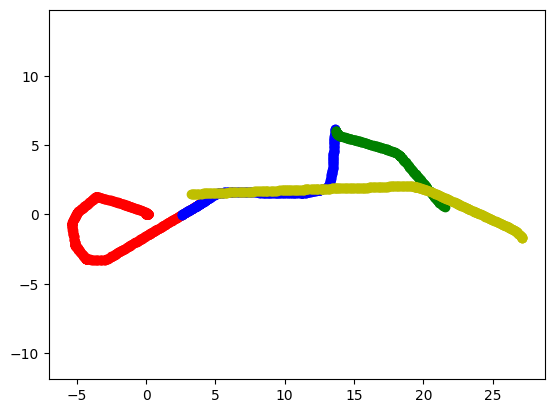

In [38]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")

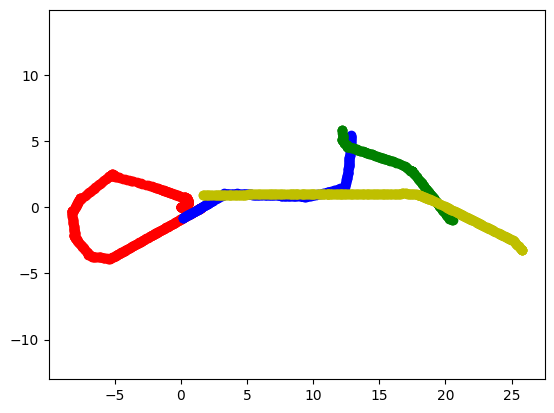

In [39]:
plt.axis('equal')
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c='r', label='1')
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c='b', label='2')
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c='g', label='3')
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c='y', label='4')

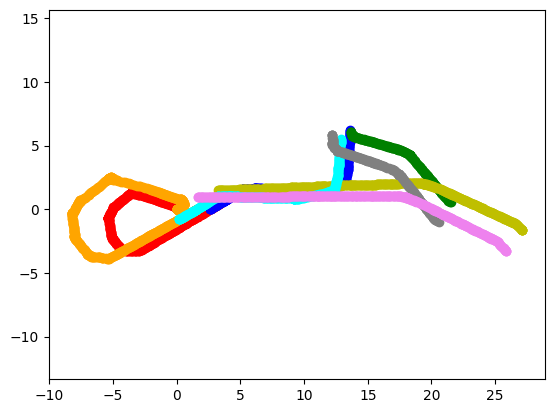

In [40]:
plt.axis('equal')
plt.scatter(arr_1[:, 1], arr_1[:, 2], c="r", label="1")
plt.scatter(arr_2[:, 1], arr_2[:, 2], c="b", label="2")
plt.scatter(arr_3[:, 1], arr_3[:, 2], c="g", label="3")
plt.scatter(arr_4[:, 1], arr_4[:, 2], c="y", label="4")
plt.scatter(arr_1_gt[:, 1], arr_1_gt[:, 2], c="orange", label="1")
plt.scatter(arr_2_gt[:, 1], arr_2_gt[:, 2], c="cyan", label="2")
plt.scatter(arr_3_gt[:, 1], arr_3_gt[:, 2], c="grey", label="3")
plt.scatter(arr_4_gt[:, 1], arr_4_gt[:, 2], c="violet", label="4")

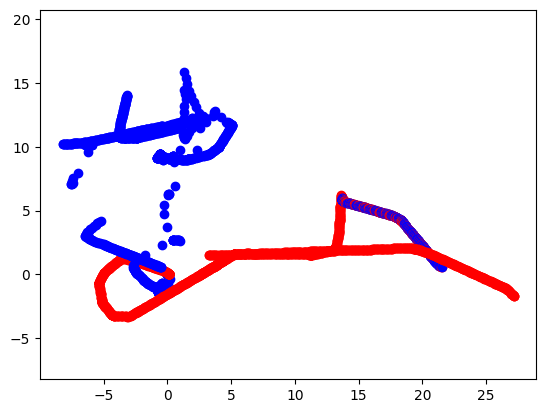

In [41]:
plt.axis('equal')
for i in initial_estimate.keys():
    plt.scatter(initial_estimate.atPose3(i).x(), initial_estimate.atPose3(i).y(), c="r")
    plt.scatter(result.atPose3(i).x(), result.atPose3(i).y(), c="b")

In [42]:
for key in initial_estimate.keys():
    gtsam_plot.plot_pose3(0, initial_estimate.atPose3(key), 0.01)

In [43]:
for key in result.keys():
    gtsam_plot.plot_pose3(0, result.atPose3(key), 0.01)

In [44]:
# extract optimized poses into numpy array and save into csv file with same input format
poses_1 = []
poses_2 = []
poses_3 = []
poses_4 = []

for key in result.keys():
    log = int(math.log10(key))
    key_ = int(key/(10**(log-1)))

    if key_ == 69:
        poses_1.append(
            [
                int(key - gtsam.symbol('a', 0)),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )
    
    if key_ == 70:
        poses_2.append(
            [
                int(key - gtsam.symbol('b', 0)),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )
    
    if key_ == 71:
        poses_3.append(
            [
                int(key - gtsam.symbol('c', 0)),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )
    
    if key_ == 72:
        poses_4.append(
            [
                int(key - gtsam.symbol('d', 0)),
                result.atPose3(key).x(),
                result.atPose3(key).y(),
                result.atPose3(key).z(),
                result.atPose3(key).rotation().toQuaternion().x(),
                result.atPose3(key).rotation().toQuaternion().y(),
                result.atPose3(key).rotation().toQuaternion().z(),
                result.atPose3(key).rotation().toQuaternion().w(),
            ]
        )

poses_1_np = np.array(poses_1)
poses_2_np = np.array(poses_2)
poses_3_np = np.array(poses_3)
poses_4_np = np.array(poses_4)

#save to csv
df_1 = pd.DataFrame(data=poses_1_np, columns=["id", "x", "y", "z", "qx", "qy", "qz", "qw"])
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/1.csv"
df_1.to_csv(csv_file_path, index=False)

df_2 = pd.DataFrame(data=poses_2_np, columns=["id", "x", "y", "z", "qx", "qy", "qz", "qw"])
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/2.csv"
df_2.to_csv(csv_file_path, index=False)

df_3 = pd.DataFrame(data=poses_3_np, columns=["id", "x", "y", "z", "qx", "qy", "qz", "qw"])
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/3.csv"
df_3.to_csv(csv_file_path, index=False)

df_4 = pd.DataFrame(data=poses_4_np, columns=["id", "x", "y", "z", "qx", "qy", "qz", "qw"])
csv_file_path = f"{base_path}/detected_loops/pose_data/sync/optimized/4.csv"
df_4.to_csv(csv_file_path, index=False)

In [47]:
print(result)

Values with 1437 values:
Value a0: (gtsam::Pose3)
R: [
	0.999999999999, 2.69030908804e-07, 1.10838059726e-06;
	-2.69034123178e-07, 0.999999999996, 2.90016897087e-06;
	-1.10837981704e-06, -2.90016926907e-06, 0.999999999995
]
t: 2.98310658838e-07  1.7236434424e-07 -8.8304710472e-09

Value a1: (gtsam::Pose3)
R: [
	0.999999999998, 4.36425444275e-07, 1.79216768933e-06;
	-4.3653998764e-07, 0.999999997957, 6.39137381291e-05;
	-1.79213979209e-06, -6.39137389114e-05, 0.999999997956
]
t: -1.23530358596e-06  1.71356387443e-05  3.23770576005e-06

Value a2: (gtsam::Pose3)
R: [
	0.999999999997, 5.79623709028e-07, 2.37142864821e-06;
	-5.79886838489e-07, 0.999999993844, 0.000110959763211;
	-2.37136431875e-06, -0.000110959764586, 0.999999993841
]
t: 1.72756057427e-05 2.08408125283e-05 5.79779923754e-06

Value a3: (gtsam::Pose3)
R: [
	0.999999999998, 4.36531109307e-07, 1.79260122518e-06;
	-4.36646989906e-07, 0.99999999791, 6.46443696377e-05;
	-1.79257300219e-06, -6.46443704203e-05, 0.999999997909
]
t: -

In [50]:
last_key = None
for i in initial_estimate.keys():
    if last_key != None:
        print(initial_estimate.atPose3(last_key).between(initial_estimate.atPose3(i)))
    last_key = i

R: [
	1, 0, 0;
	0, 1, 7.48298219357e-08;
	0, -7.48298219357e-08, 1
]
t: -6.47610802339e-07  6.03100535053e-11  5.61460181565e-15

R: [
	1, 0, 0;
	0, 1, 3.1504786928e-08;
	0, -3.1504786928e-08, 1
]
t: -3.64838583861e-07  3.39985610715e-11  3.16766122403e-15

R: [
	1, 0, 0;
	0, 1, 1.96526822741e-08;
	0, -1.96526822742e-08, 1
]
t: -2.12932496624e-07  1.98471249637e-11  1.84979083748e-15

R: [
	1, 0, 0;
	0, 1, 5.11878879715e-08;
	0, -5.11878879715e-08, 1
]
t: -5.76736718898e-07  5.37782334132e-11  5.01329334929e-15

R: [
	1, 0, 0;
	0, 1, 1.44373293644e-08;
	0, -1.44373293645e-08, 1
]
t: -2.16009853013e-07  2.01495418468e-11   1.8794040871e-15

R: [
	1, 0, 0;
	0, 1, 7.61037097723e-09;
	0, -7.61037097723e-09, 1
]
t: -2.15864644552e-07  2.01381518062e-11  1.87863244731e-15

R: [
	1, 0, 0;
	0, 1, 4.06772332633e-08;
	0, -4.06772332633e-08, 1
]
t: -4.34901086619e-07  4.05837149312e-11  3.78625130289e-15

R: [
	1, 0, 0;
	0, 0.999999999354, -3.59326400395e-05;
	0, 3.59326400395e-05, 0.999999999354